In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from sklearn.preprocessing import label_binarize


In [3]:
# Define transformations for the datasets
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalize with ImageNet means and stds
                         [0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = datasets.ImageFolder(root='./Potato/Train', transform=transform)
valid_dataset = datasets.ImageFolder(root='./Potato/Valid', transform=transform)
test_dataset = datasets.ImageFolder(root='./Potato/Test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [4]:
# Unnormalize helper
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * std + mean


def preview_one_image_per_class(dataset, class_names):
    shown_classes = set()
    samples = []

    for img, label in dataset:
        if label not in shown_classes:
            shown_classes.add(label)
            samples.append((img, label))
        if len(shown_classes) == len(class_names):
            break

    plt.figure(figsize=(15, 3))
    for i, (img, label) in enumerate(samples):
        # Unnormalize
        img = unnormalize(img).permute(1, 2, 0).numpy().clip(0, 1)

        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis('off')

    plt.suptitle("One Sample per Class", fontsize=14)
    plt.tight_layout()
    plt.show()


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


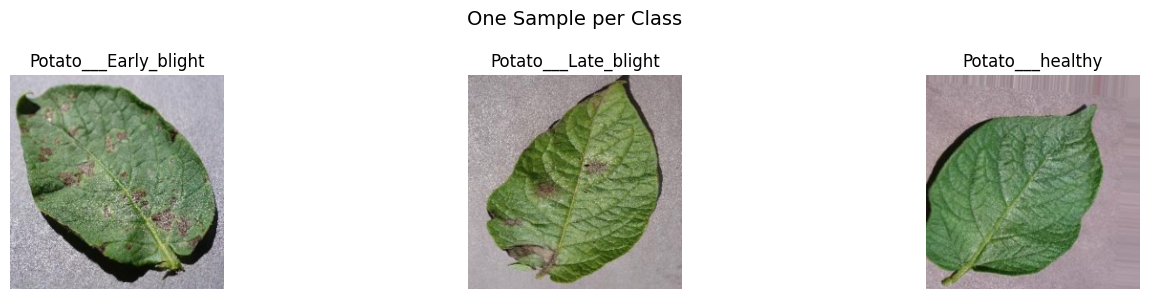

In [5]:
class_names = train_dataset.classes
print(class_names)

preview_one_image_per_class(train_dataset, class_names)

In [5]:
class PotoatoModel(nn.Module):
    def __init__(self):
        super(PotoatoModel, self).__init__()
        # Define the CNN architecture that processes the 3 classes
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 3)
        
    def forward(self, x):
        # Forward pass through the CNN
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # Output layer for 3 classes
        x = F.log_softmax(x, dim=1)
        
        return x
    
# Initialize the model
model = PotoatoModel()
# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [6]:

# Training loop
num_epochs = 10
loss_over_epochs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    # Calculate average loss for the epoch
    average_loss = running_loss / len(train_loader)
    loss_over_epochs.append(average_loss)

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')



Epoch 1/10, Loss: 11.6430
Epoch 2/10, Loss: 2.1739
Epoch 3/10, Loss: 1.9867
Epoch 4/10, Loss: 1.2950
Epoch 5/10, Loss: 0.7169
Epoch 6/10, Loss: 0.6916
Epoch 7/10, Loss: 0.2676
Epoch 8/10, Loss: 1.4140
Epoch 9/10, Loss: 0.6238
Epoch 10/10, Loss: 0.2292


In [7]:
# Validation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')
# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
# Save the trained model
torch.save(model.state_dict(), 'potato_model.pth')

Validation Accuracy: 96.67%
Test Accuracy: 97.33%


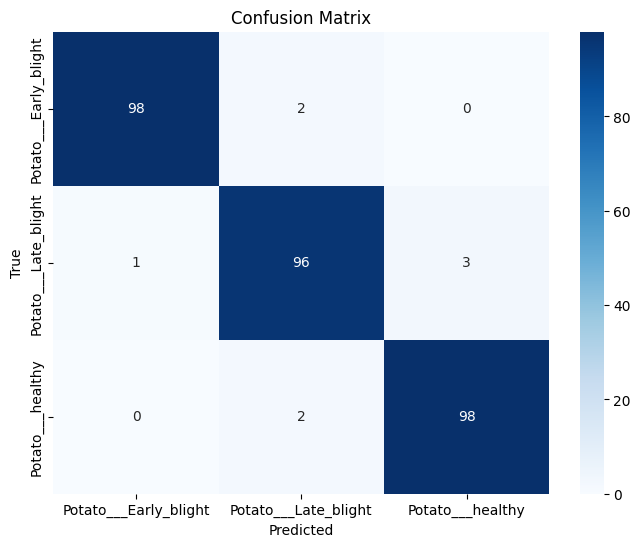

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.99      0.98      0.98       100
 Potato___Late_blight       0.96      0.96      0.96       100
     Potato___healthy       0.97      0.98      0.98       100

             accuracy                           0.97       300
            macro avg       0.97      0.97      0.97       300
         weighted avg       0.97      0.97      0.97       300



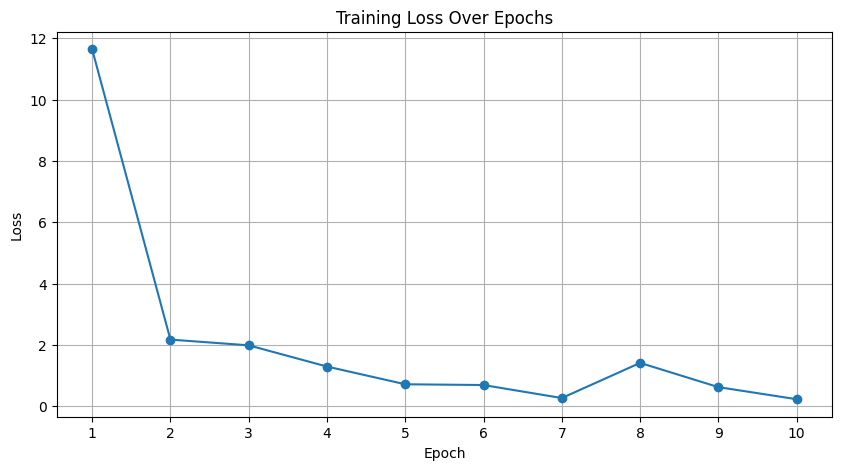

In [ ]:
# eval metrics (confusion matrix, classification report)

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)
# Plot training loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_over_epochs, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.grid()
plt.show()

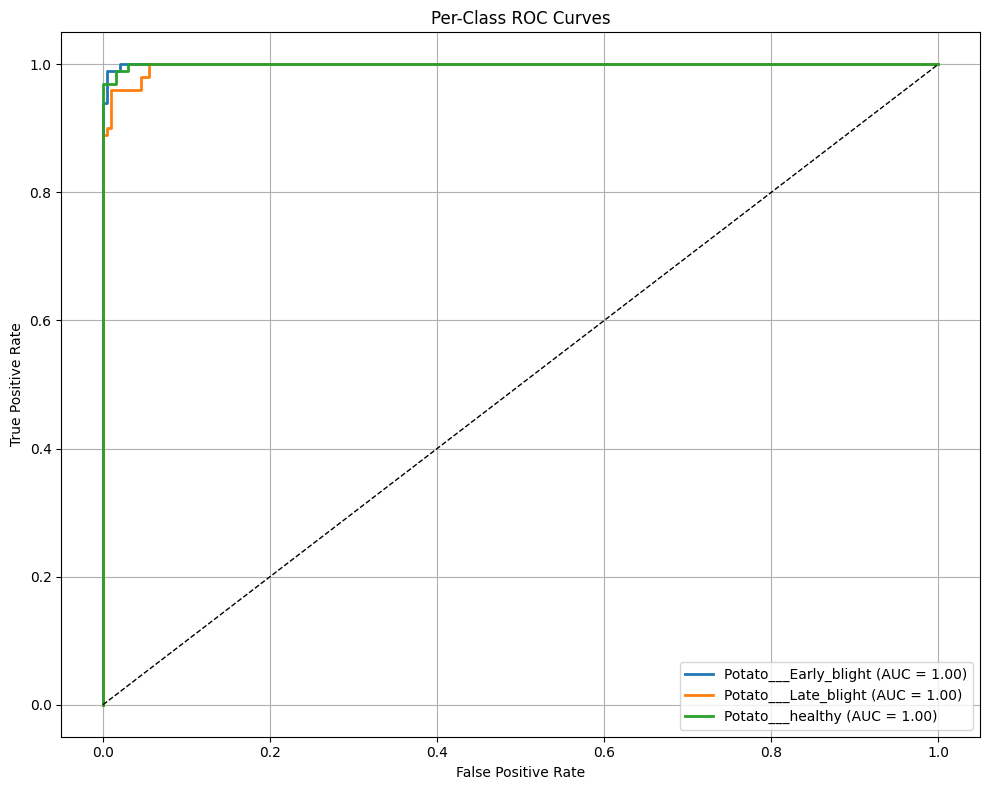

In [ ]:
def plot_roc_curves(model, data_loader, class_names):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    y_true = label_binarize(all_labels, classes=list(range(len(class_names))))
    y_score = np.array(all_probs)

    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Per-Class ROC Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_roc_curves(model, test_loader, class_names)


In [11]:
def plot_predictions(model, data_loader, class_names, num_images=15, show_errors_only=False, error_type='both'):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        predicted = torch.argmax(probs, dim=1)
        confidences = probs[range(len(predicted)), predicted]

    # Identify FP and FN
    errors = []
    for i in range(len(images)):
        pred = predicted[i].item()
        label = labels[i].item()
        if pred != label:
            if error_type == 'fp' and pred != label:
                errors.append(i)
            elif error_type == 'fn' and label != pred:
                errors.append(i)
            elif error_type == 'both':
                errors.append(i)

    indices_to_plot = errors if show_errors_only else list(range(len(images)))
    num_images = min(num_images, len(indices_to_plot))
    rows = (num_images + 4) // 5

    plt.figure(figsize=(15, 3 * rows))

    for idx, i in enumerate(indices_to_plot[:num_images]):
        img = unnormalize(images[i].cpu()).permute(1, 2, 0).numpy().clip(0, 1)

        plt.subplot(rows, 5, idx + 1)
        plt.imshow(img)
        plt.title(f'Pred: {class_names[predicted[i]]}\n'
                  f'({confidences[i]*100:.1f}%)\n'
                  f'Actual: {class_names[labels[i]]}',
                  fontsize=9)
        plt.axis('off')

    title = f"{error_type.upper()}s Only" if show_errors_only else "All Predictions"
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


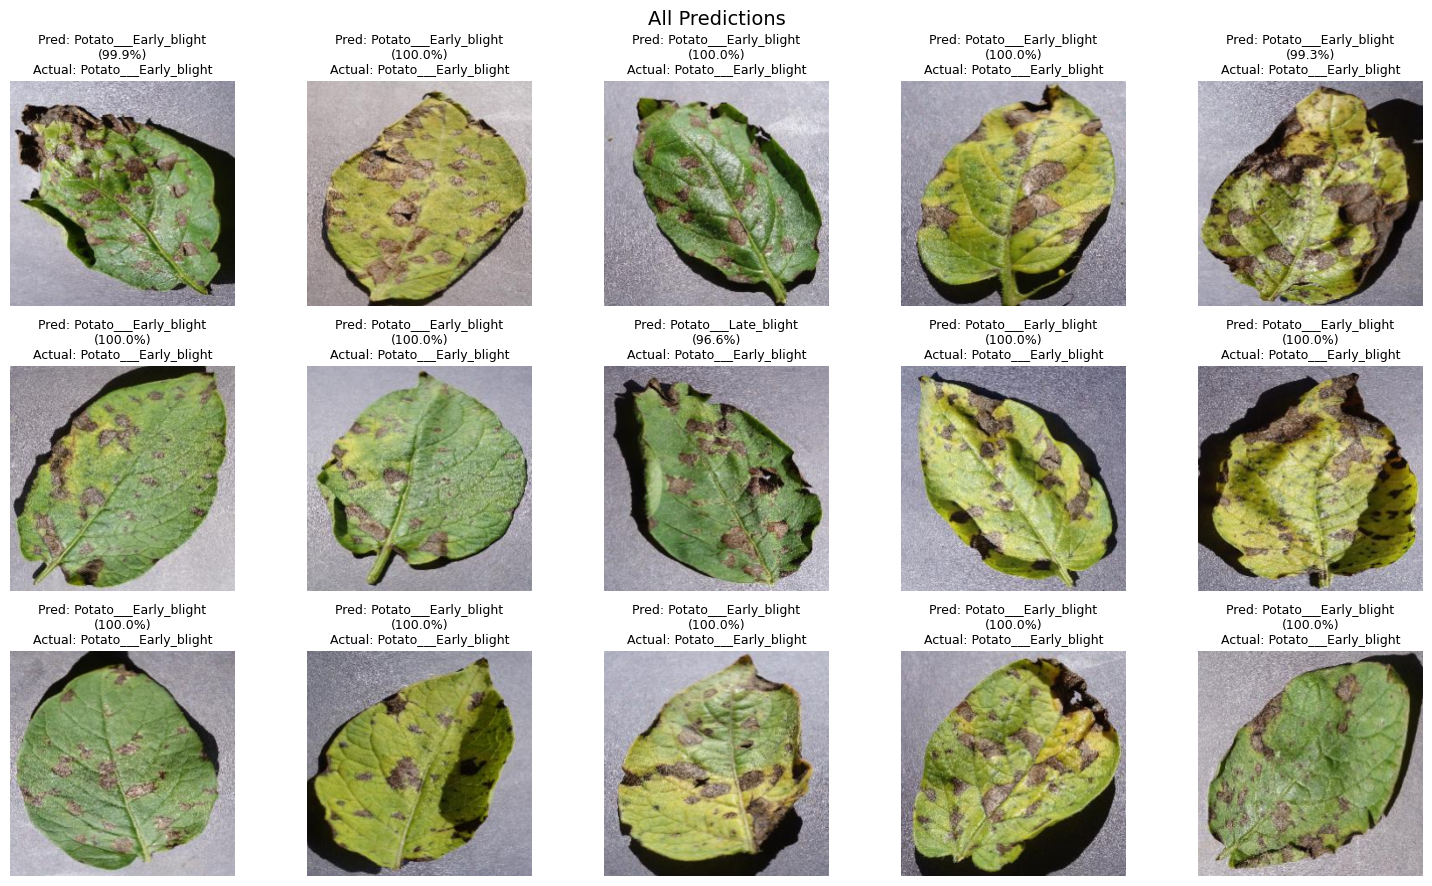

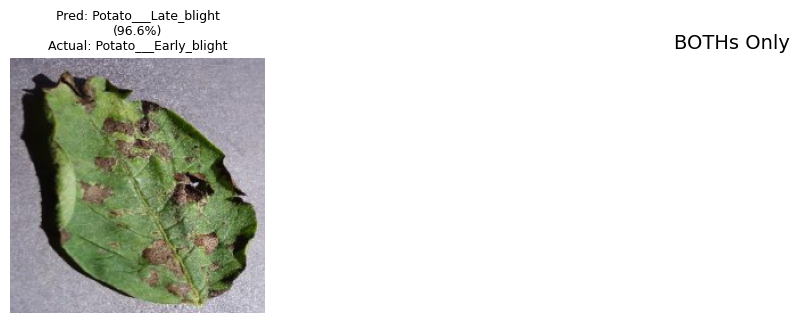

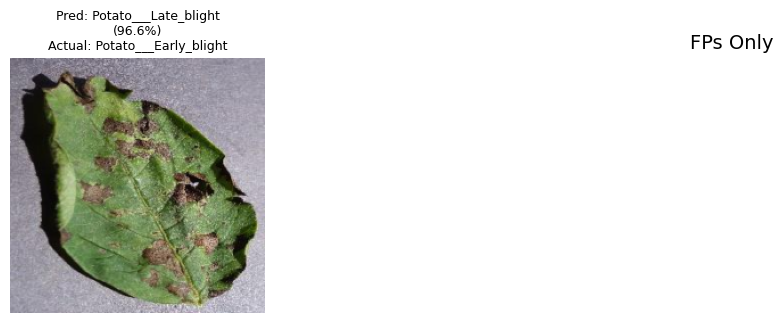

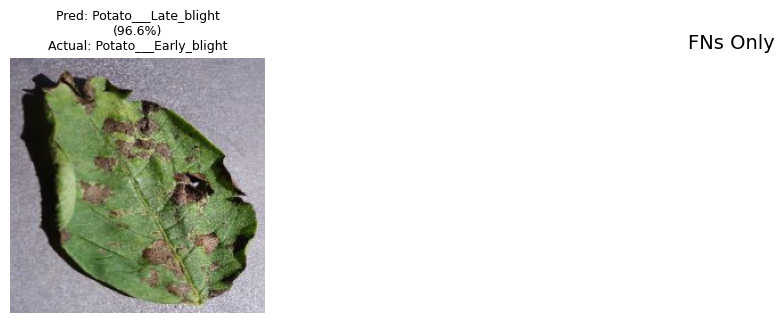

In [12]:
plot_predictions(model, test_loader, class_names, num_images=15)
plot_predictions(model, test_loader, class_names, num_images=15, show_errors_only=True)
plot_predictions(model, test_loader, class_names, num_images=15, show_errors_only=True, error_type='fp')
plot_predictions(model, test_loader, class_names, num_images=15, show_errors_only=True, error_type='fn')
